In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10


In [2]:
# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [3]:
# Autoencoder with nearest Upsampling
class Autoencoder_nearest(nn.Module):
    def __init__(self):
        super(Autoencoder_nearest, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 14*14),
            nn.ReLU()
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest', align_corners=False if 'nearest' != 'nearest' else None)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 14, 14)
        x = self.upsample(x)
        return x


In [4]:
# Autoencoder with bilinear Upsampling
class Autoencoder_bilinear(nn.Module):
    def __init__(self):
        super(Autoencoder_bilinear, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 14*14),
            nn.ReLU()
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False if 'bilinear' != 'nearest' else None)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 14, 14)
        x = self.upsample(x)
        return x


In [5]:
# Autoencoder with bicubic Upsampling
class Autoencoder_bicubic(nn.Module):
    def __init__(self):
        super(Autoencoder_bicubic, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 14*14),
            nn.ReLU()
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False if 'bicubic' != 'nearest' else None)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 14, 14)
        x = self.upsample(x)
        return x


In [6]:
def train_autoencoder(model_class, label):
    model = model_class()
    model = model.cuda() if torch.cuda.is_available() else model
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.cuda() if torch.cuda.is_available() else img
            img_flat = img.view(img.size(0), -1)

            output = model(img_flat)
            output_flat = output.view(img.size(0), -1)

            loss = criterion(output_flat, img.view(img.size(0), -1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f'{label} Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return losses


Nearest Epoch [1/10], Loss: 0.0429
Nearest Epoch [2/10], Loss: 0.0424
Nearest Epoch [3/10], Loss: 0.0334
Nearest Epoch [4/10], Loss: 0.0368
Nearest Epoch [5/10], Loss: 0.0398
Nearest Epoch [6/10], Loss: 0.0381
Nearest Epoch [7/10], Loss: 0.0331
Nearest Epoch [8/10], Loss: 0.0347
Nearest Epoch [9/10], Loss: 0.0380
Nearest Epoch [10/10], Loss: 0.0371
Bilinear Epoch [1/10], Loss: 0.0305
Bilinear Epoch [2/10], Loss: 0.0322
Bilinear Epoch [3/10], Loss: 0.0269
Bilinear Epoch [4/10], Loss: 0.0296
Bilinear Epoch [5/10], Loss: 0.0265
Bilinear Epoch [6/10], Loss: 0.0271
Bilinear Epoch [7/10], Loss: 0.0274
Bilinear Epoch [8/10], Loss: 0.0218
Bilinear Epoch [9/10], Loss: 0.0223
Bilinear Epoch [10/10], Loss: 0.0227
Bicubic Epoch [1/10], Loss: 0.0344
Bicubic Epoch [2/10], Loss: 0.0288
Bicubic Epoch [3/10], Loss: 0.0252
Bicubic Epoch [4/10], Loss: 0.0296
Bicubic Epoch [5/10], Loss: 0.0251
Bicubic Epoch [6/10], Loss: 0.0227
Bicubic Epoch [7/10], Loss: 0.0239
Bicubic Epoch [8/10], Loss: 0.0266
Bicubic 

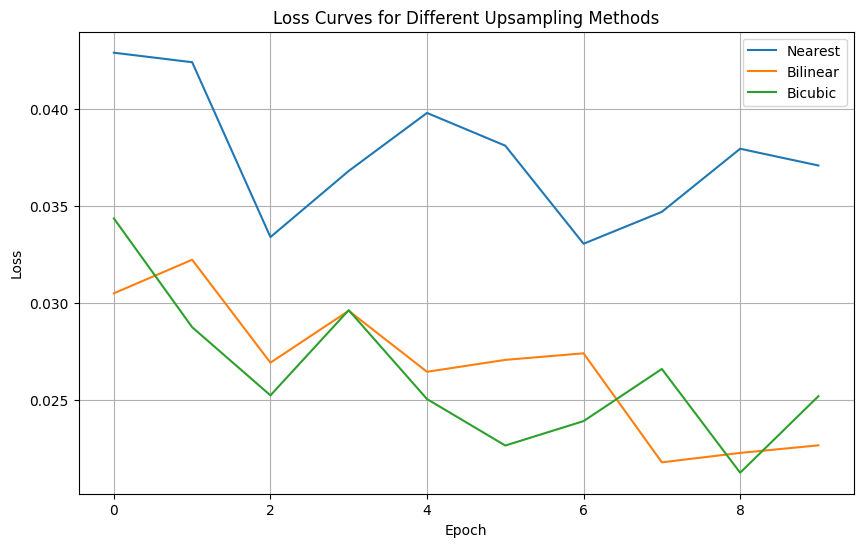

In [7]:
loss_nearest = train_autoencoder(Autoencoder_nearest, "Nearest")
loss_bilinear = train_autoencoder(Autoencoder_bilinear, "Bilinear")
loss_bicubic = train_autoencoder(Autoencoder_bicubic, "Bicubic")

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(loss_nearest, label='Nearest')
plt.plot(loss_bilinear, label='Bilinear')
plt.plot(loss_bicubic, label='Bicubic')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Upsampling Methods')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Load FashionMNIST test dataset
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_image, _ = next(iter(test_loader))
test_image_flat = test_image.view(1, -1)
test_image = test_image.cuda() if torch.cuda.is_available() else test_image
test_image_flat = test_image_flat.cuda() if torch.cuda.is_available() else test_image_flat


In [9]:
def load_model(model_class, path):
    model = model_class()
    model.load_state_dict(torch.load(path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
    model = model.cuda() if torch.cuda.is_available() else model
    model.eval()
    return model


In [11]:
# Train and save models temporarily for Fourier analysis (not efficient, but ensures compatibility)
torch.save(Autoencoder_nearest().state_dict(), 'nearest.pth')
torch.save(Autoencoder_bilinear().state_dict(), 'bilinear.pth')
torch.save(Autoencoder_bicubic().state_dict(), 'bicubic.pth')


In [12]:
model_nearest = load_model(Autoencoder_nearest, 'nearest.pth')
model_bilinear = load_model(Autoencoder_bilinear, 'bilinear.pth')
model_bicubic = load_model(Autoencoder_bicubic, 'bicubic.pth')


/tmp/ipykernel_182524/3276815777.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location='cuda' if torch.cuda.is_available() 

In [13]:
def fft_image(img_tensor):
    img_np = img_tensor.squeeze().cpu().detach().numpy()
    f = torch.fft.fft2(torch.tensor(img_np))
    fshift = torch.fft.fftshift(f)
    magnitude_spectrum = torch.log(torch.abs(fshift) + 1e-7)
    return magnitude_spectrum

with torch.no_grad():
    recon_nearest = model_nearest(test_image_flat).cpu()
    recon_bilinear = model_bilinear(test_image_flat).cpu()
    recon_bicubic = model_bicubic(test_image_flat).cpu()

# Reshape outputs to 1x28x28
recon_nearest = recon_nearest.view(1, 1, 28, 28)
recon_bilinear = recon_bilinear.view(1, 1, 28, 28)
recon_bicubic = recon_bicubic.view(1, 1, 28, 28)


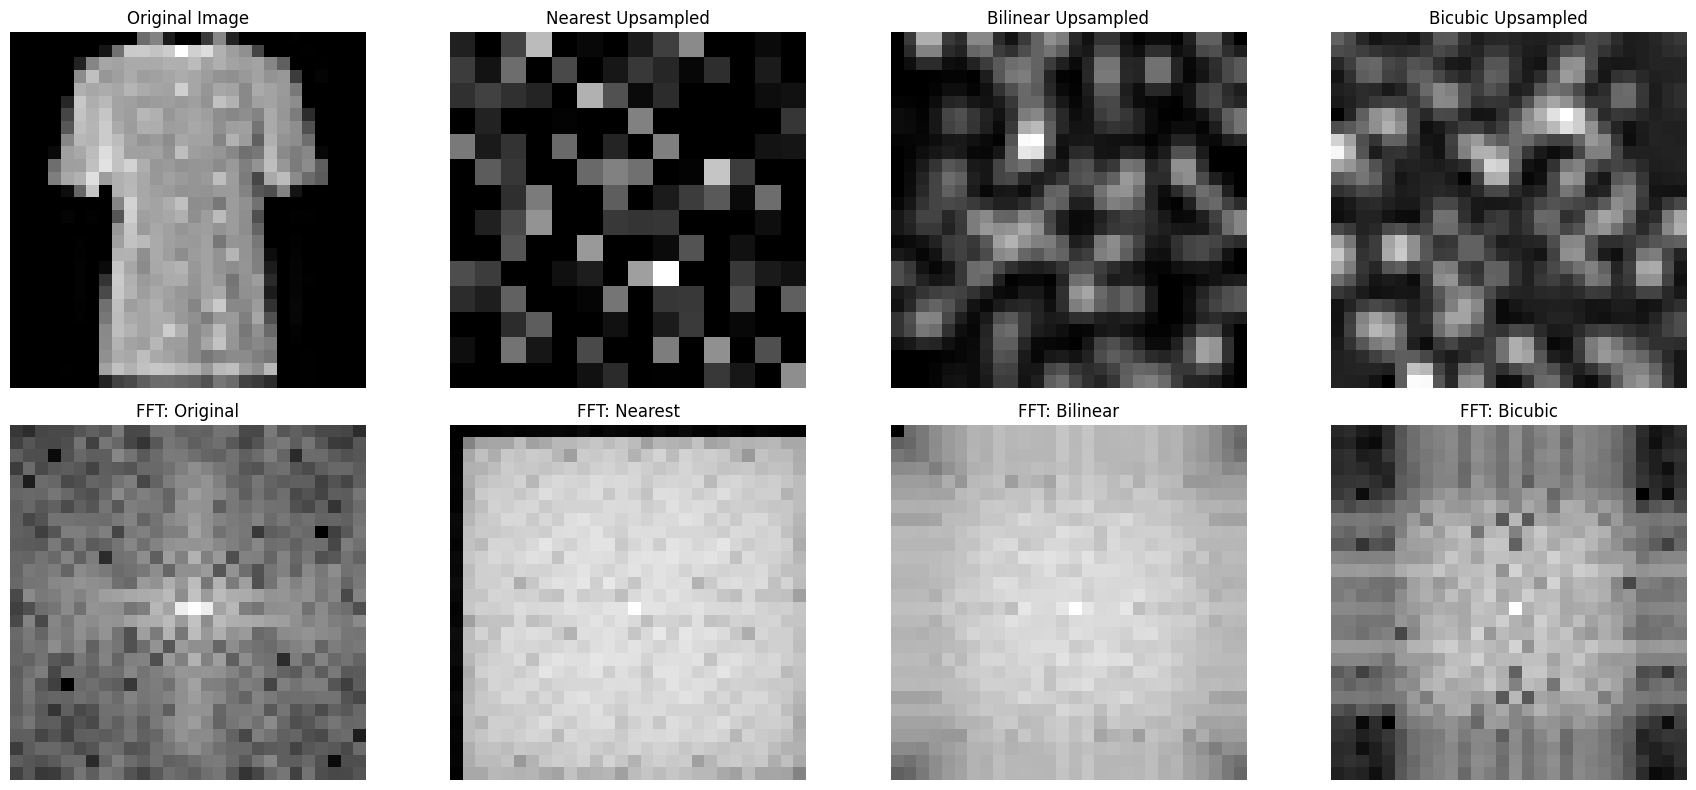

In [ ]:
# Plot FFTs
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

# Original image
axs[0, 0].imshow(test_image.squeeze().cpu(), cmap='gray')
axs[0, 0].set_title('Original Image')

# Reconstructions
axs[0, 1].imshow(recon_nearest.squeeze(), cmap='gray')
axs[0, 1].set_title('Nearest Upsampled')

axs[0, 2].imshow(recon_bilinear.squeeze(), cmap='gray')
axs[0, 2].set_title('Bilinear Upsampled')

axs[0, 3].imshow(recon_bicubic.squeeze(), cmap='gray')
axs[0, 3].set_title('Bicubic Upsampled')

# FFTs
axs[1, 0].imshow(fft_image(test_image).numpy(), cmap='viridis')
axs[1, 0].set_title('FFT: Original')

axs[1, 1].imshow(fft_image(recon_nearest).numpy(), cmap='viridis')
axs[1, 1].set_title('FFT: Nearest')

axs[1, 2].imshow(fft_image(recon_bilinear).numpy(), cmap='viridis')
axs[1, 2].set_title('FFT: Bilinear')

axs[1, 3].imshow(fft_image(recon_bicubic).numpy(), cmap='viridis')
axs[1, 3].set_title('FFT: Bicubic')

for ax in axs.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()
